In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hydra import initialize, compose
from glob import glob

from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot, plot_util
from mejiro.lenses import test
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert, bkg
from mejiro.utils import util

In [2]:
lens = test.TutorialLens()
model = lens.get_array(num_pix=45, side=4.95)

In [3]:
noise_list = []

for i in range(10):
    calc = build_default_calc('roman', 'wfi', 'imaging')
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.

    # set scene size settings
    calc['configuration']['max_scene_size'] = 5

    # set instrument
    calc['configuration']['instrument']['filter'] = 'f184'  # e.g. 'f106'

    # set detector
    calc['configuration']['detector']['ma_table_name'] = 'hlwas_imaging'

    # turn off noise sources
    calc['calculation'] = pandeia_input.get_calculation_dict(init=False)

    # set background
    calc['background'] = bkg.get_background(suppress_output=False)

    # add an extra point source far out to force maximum scene size
    calc['scene'].append(build_default_source(geometry='point', telescope='roman'))
    calc['scene'][1]['position']['x_offset'] = 100
    calc['scene'][1]['position']['y_offset'] = 100

    image, _ = pandeia_input.get_pandeia_image(calc)
    noise_list.append(image)

RA: 26.667084196006005, DEC: -30.09699184693183
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 18.81073334641858, DEC: -29.36629356532375
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 27.62019918520227, DEC: -24.303415830072222
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 17.598764503757113, DEC: -37.452410524321536
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:01
RA: 30.94609598626652, DEC: -24.291338783653824
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 34.60243121426029, DEC: -35.549689047078665
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 21.593242923575325, DEC: -23.278055436593394
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 31.42361533656562, DEC: -21.198414130870486
Performing Pandeia calculation...
Pandeia calculation complete in 0:00:00
RA: 26.404757437041788,

In [4]:
last_array = noise_list[-1]

for i, array in enumerate(noise_list):
    print(np.count_nonzero(last_array - array))

2025
2025
2025
2025
2025
2025
2025
2025
2025
0


In [5]:
last_array = noise_list[-1]
residual_list = [i - last_array for i in noise_list[:-1]]

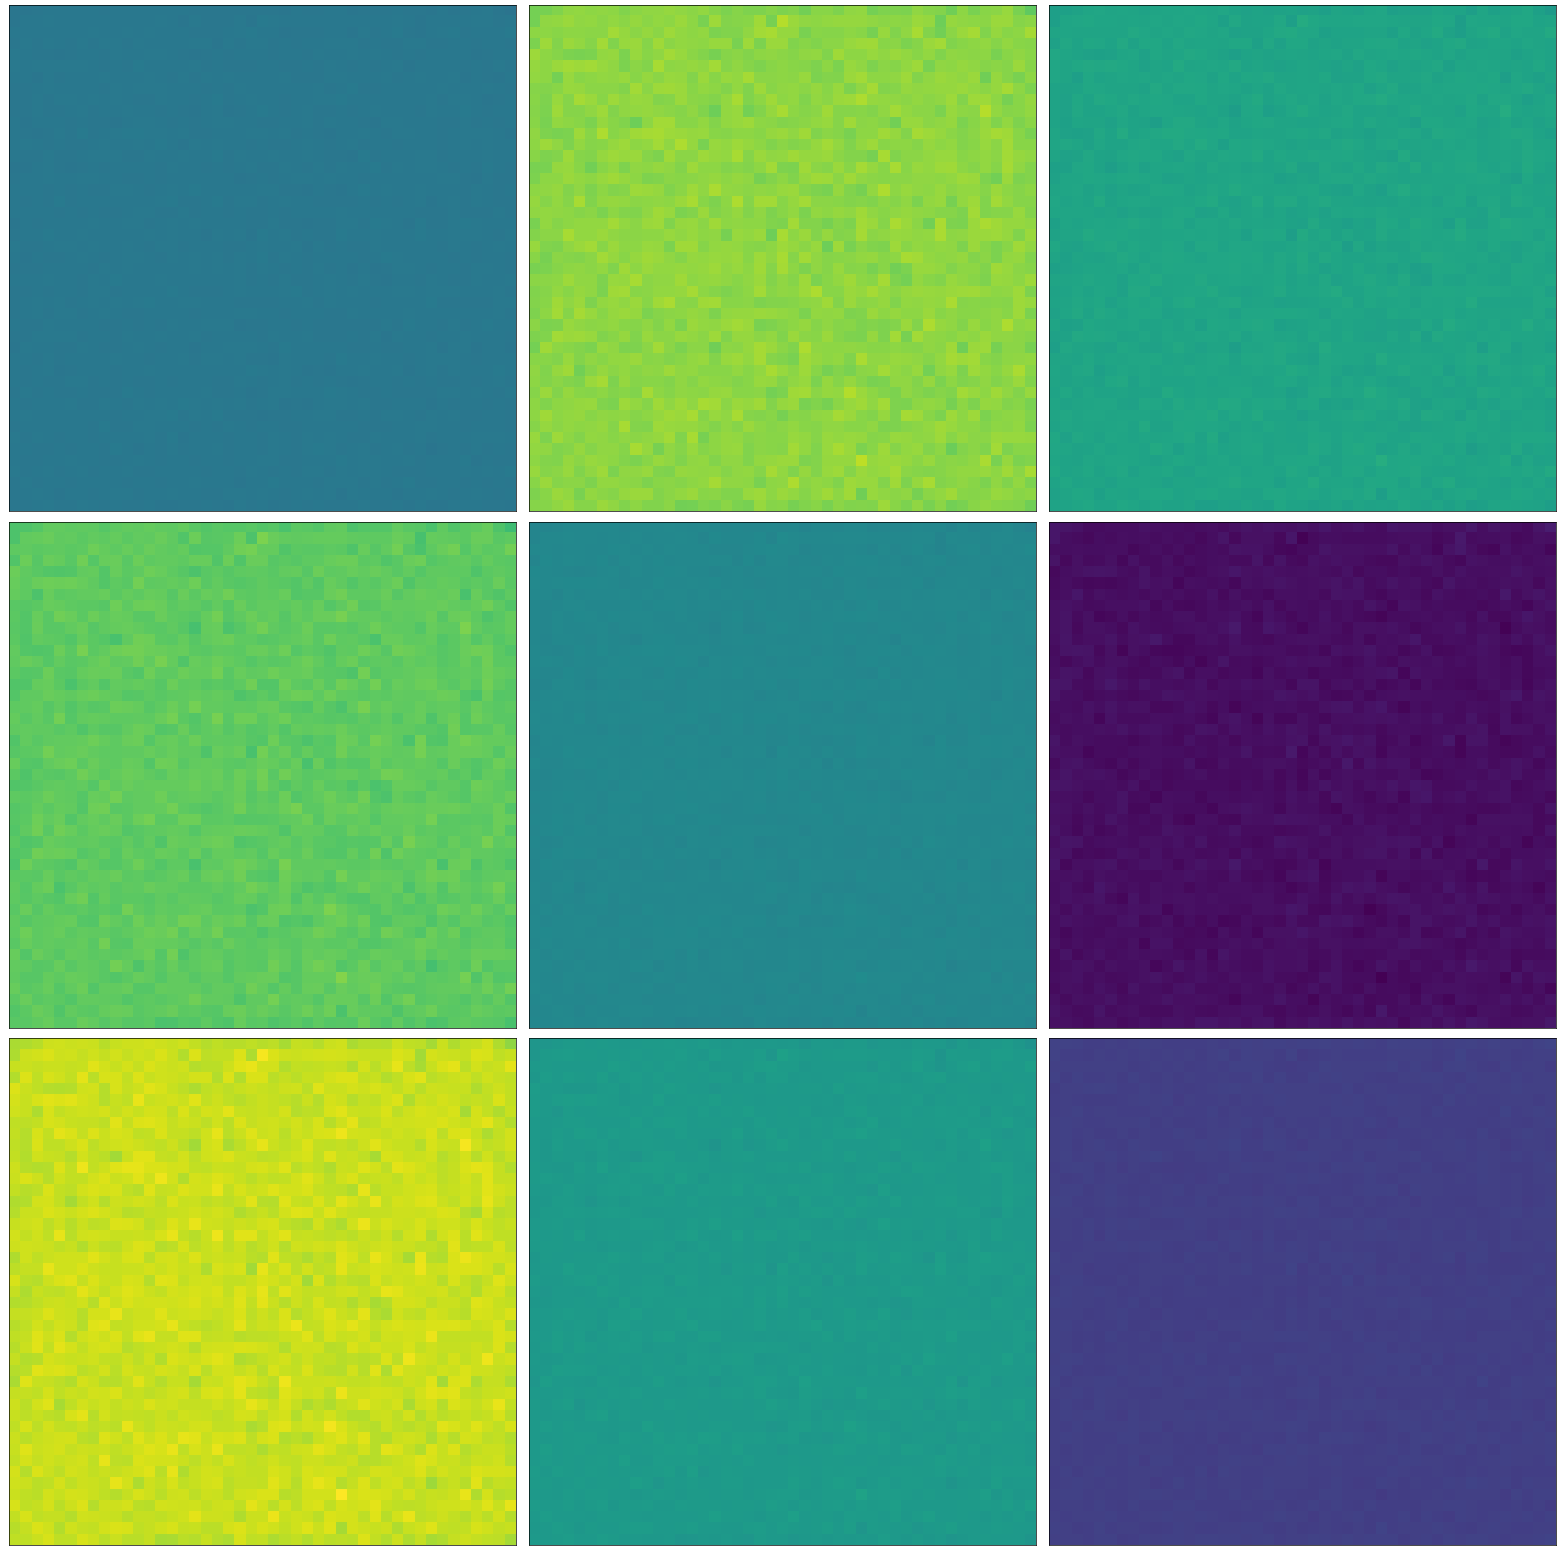

In [6]:
save_path = os.path.join(figure_dir, 'jwst_noise_residuals.png')
plot.plot_grid(residual_list, side=3, log10=False, colorbar=True, save=save_path)

In [7]:
array_list = noise_list
colorbar=True
side=3
cmap='viridis'
log10=False

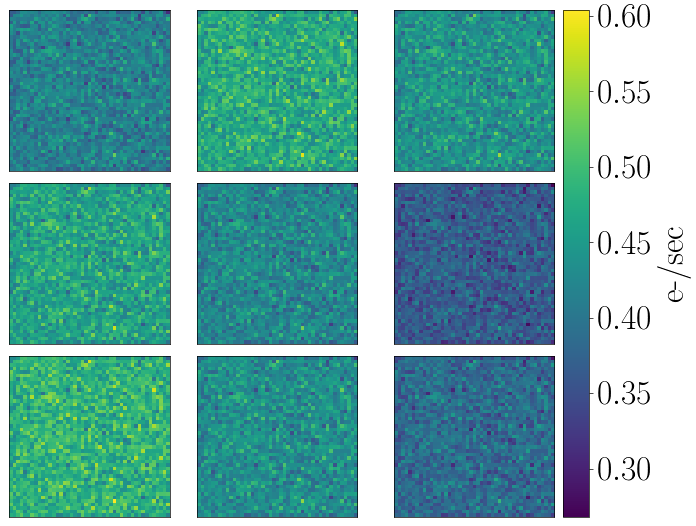

In [8]:
fontsize = 24
import matplotlib
matplotlib.rcParams.update({'font.size': fontsize})

array_list = array_list[:side ** 2]
if colorbar:
    vmin, vmax = plot_util.get_min_max(array_list)

fig, ax = plt.subplots(nrows=side, ncols=side, constrained_layout=True)

for i, image in enumerate(array_list):
    if log10:
        image = np.log10(image)
    if colorbar:
        axis = ax[i // side, i % side].imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        axis = ax[i // side, i % side].imshow(image, cmap=cmap)
    ax[i // side, i % side].get_xaxis().set_visible(False)
    ax[i // side, i % side].get_yaxis().set_visible(False)

cbar = plt.colorbar(axis, ax=ax[:, side - 1], location='right')
cbar.set_label('e-/sec', rotation=90)

save_path = os.path.join(figure_dir, 'jwst_noise.png')
plt.savefig(save_path)
plt.show()

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

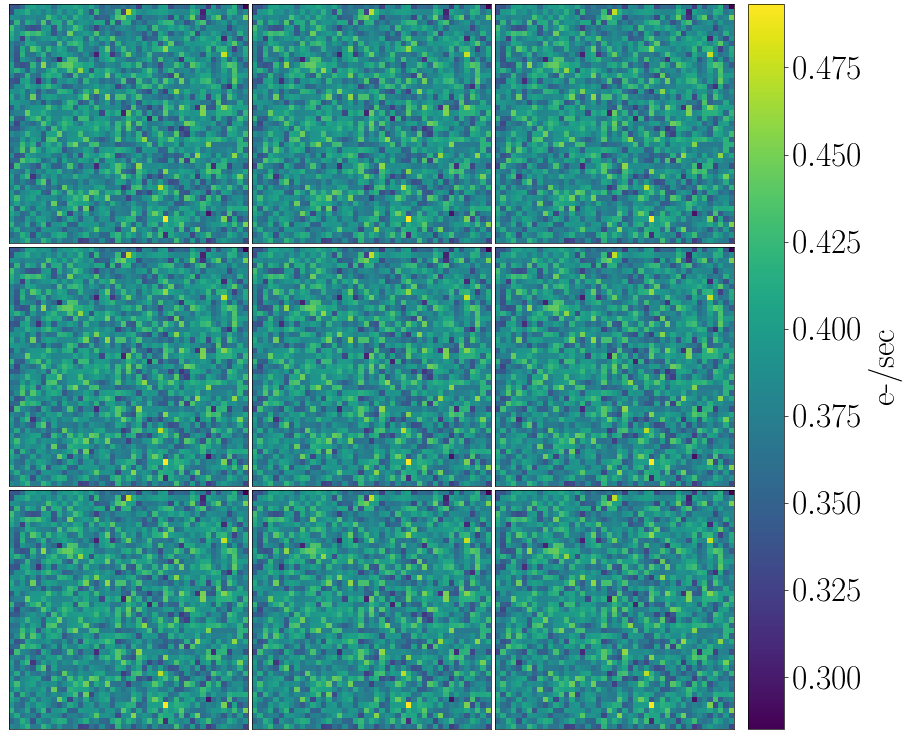

In [36]:
fig = plt.figure(figsize=(10,10))

colorbar=True

cbar_kwargs = {
    'cbar_location': 'right',
    'cbar_mode': 'single',
    'cbar_pad': '2%',
    'cbar_size': '5%'
}

if colorbar:
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=(side, side), 
        axes_pad=0.04,
        label_mode='all',
        share_all=True,
        **cbar_kwargs)
else:
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=(side, side), 
        axes_pad=0.04,
        label_mode='all',
        share_all=True)

for i, ax in enumerate(grid):
    if log10:
        array_list[i] = np.log10(array_list[i])
    im = ax.imshow(array_list[i], cmap=cmap)

if colorbar:
    cbar = grid.cbar_axes[0].colorbar(im)
    cbar.set_label('e-/sec', rotation=90)
    for cax in grid.cbar_axes:
        cax.tick_params(labeltop=False)

grid.axes_llc.set(xticks=[], yticks=[])

plt.show()